In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from constants import *

2024-04-30 14:08:11.294943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Colab versions: ('2.15.0', '2.15.0')
keras.__version__, tf.__version__

('2.15.0', '2.15.0')

# Model Evaluation 

The purpose of this notebook is to evaluate several trained CNN architectures, each on different variations of the data. We'll be evaluating 2 different Convolutional Neural Network architectures.


Models: 
1) Simple LeNet-5 architecture trained only using our retinal datasets
2) Large Pre-trained CNN architecture VGG-19  (pre-trained on ImageNet dataset)

Data Variations: 
1) Binary classification of retinal images as health or diseased
2) Multi-label classification of retinal images as healthy or diseased with DR, MH, or ODC retinal diseased

### Load Data

In [3]:
batch_size = 32
train_gen = tf.keras.utils.image_dataset_from_directory(
            TRAIN_DIR,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(300, 300),
            shuffle=False, # don't shuffle for evaluation purposes 
            seed=SEED,
            interpolation='bilinear',
            crop_to_aspect_ratio=True,
        )

test_gen = tf.keras.utils.image_dataset_from_directory(
            TEST_DIR,
            labels='inferred',
            label_mode='int',
            class_names=None,
            color_mode='rgb',
            batch_size=batch_size,
            image_size=(300, 300),
            shuffle=False, # don't shuffle for evaluation purposes 
            seed=SEED,
            interpolation='bilinear',
            crop_to_aspect_ratio=True,
        )

Found 9602 files belonging to 2 classes.
Found 995 files belonging to 2 classes.


In [39]:
# sanity check
for (x, y) in train_gen.take(10):
    print(x.shape, x[0][0].numpy().min(), x[0][0].numpy().max(), y.shape)
    break
print(x.numpy().min(), x.numpy().max())

(32, 300, 300, 3) 155.0 248.0 (32,)
0.0 255.0


In [5]:
# sanity check
for (x, y) in test_gen.take(10):
    print(x.shape, x[0][0].numpy().min(), x[0][0].numpy().max(), y.shape)
    break
print(x.numpy().min(), x.numpy().max())

(32, 300, 300, 3) 37.0 189.0 (32,)
0.0 255.0


In [6]:
def get_class_count(data_gen):
    # Get the class names from the dataset
    class_names = data_gen.class_names

    # Initialize a dictionary to store the counts of each class
    class_counts = {class_name: 0 for class_name in class_names}

    # Iterate through the dataset to count the occurrences of each class
    for images, labels in data_gen:
        for label in labels:
            class_name = class_names[label.numpy()]
            class_counts[class_name] += 1

    # Print the count of each class
    for class_name, count in class_counts.items():
        print(f'{class_name}: {count}')

# classes are balanced
# naive baseline accuracy is 50% 
get_class_count(test_gen)

benign: 500
malignant: 500


## Evaluate Trained Models

Let's see how our trained models perform across several metrics on the test set. 

In [4]:
# load trained models
alexnet_model = keras.saving.load_model(MODEL_DIR+"alex_net_model.keras")
densenet121_model = keras.saving.load_model(MODEL_DIR+"DenseNet121_model.keras")
InceptionResNetV2_model = keras.saving.load_model(MODEL_DIR+"InceptionResNetV2_model.keras")
Xception_model = keras.saving.load_model(MODEL_DIR+"Xception_model.keras")

In [ ]:
# get predicted probabilities 
y_pred_prob_test_alexnet = alexnet_model.predict(test_gen)
y_pred_prob_test_densenet = densenet121_model.predict(test_gen)

y_pred_prob_test_inception = InceptionResNetV2_model.predict(test_gen)
y_pred_prob_test_xception = Xception_model.predict(test_gen)

In [9]:
def apply_thresh(data, thresh=.5): 
    return (data > thresh).astype("int32")

# get predicted labels
y_pred_test_alexnet = apply_thresh(y_pred_prob_test_alexnet)
y_pred_test_densenet = apply_thresh(y_pred_prob_test_densenet)

y_pred_test_inception = apply_thresh(y_pred_prob_test_inception)
y_pred_test_xception = apply_thresh(y_pred_prob_test_xception)

In [6]:
# pull labels out of generator and put into flat list 
y_test = []
for images, batch_labels in test_gen:
    y_test.extend(batch_labels.numpy())

### ROC Plots 

Let's look at ROC plots first to determine which model performs best across all prediction probability thresholds. We'll then find the best performing threshold for that model and look at more metrics. 

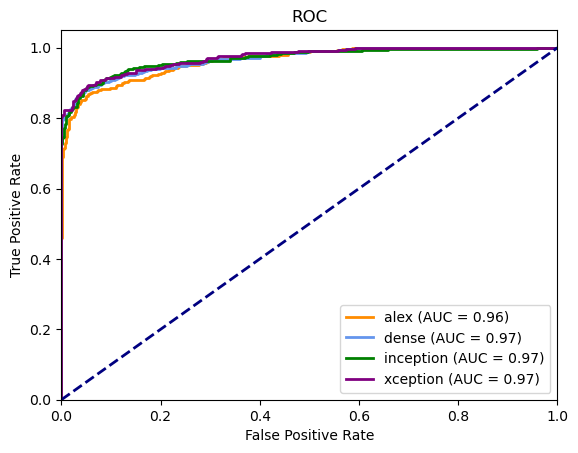

In [30]:

# Compute ROC curve and AUC for each model
fpr_model1, tpr_model1, _ = roc_curve(y_test, y_pred_prob_test_alexnet.flatten())
roc_auc_model1 = auc(fpr_model1, tpr_model1)

fpr_model2, tpr_model2, _ = roc_curve(y_test, y_pred_prob_test_densenet.flatten())
roc_auc_model2 = auc(fpr_model2, tpr_model2)

fpr_model3, tpr_model3, _ = roc_curve(y_test, y_pred_prob_test_inception.flatten())
roc_auc_model3 = auc(fpr_model3, tpr_model3)

fpr_model4, tpr_model4, _ = roc_curve(y_test, y_pred_prob_test_xception.flatten())
roc_auc_model4 = auc(fpr_model4, tpr_model4)

# Plot ROC curve
plt.figure()
plt.plot(fpr_model1, tpr_model1, color='darkorange', lw=2, label=f'alex (AUC = {roc_auc_model1:.2f})')
plt.plot(fpr_model2, tpr_model2, color='cornflowerblue', lw=2, label=f'dense (AUC = {roc_auc_model2:.2f})')
plt.plot(fpr_model3, tpr_model3, color='green', lw=2, label=f'inception (AUC = {roc_auc_model3:.2f})')
plt.plot(fpr_model4, tpr_model4, color='purple', lw=2, label=f'xception (AUC = {roc_auc_model4:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()


We can see from the ROC that all models perform nearly identical to each other. With transfer models performing slightly better than AlexNet. While there is further analysis we could make, for our purposes it will due to pick one of the transfer models. Scan for the optimum threshold values, and pick a model based on the Confusion Matrix outcomes. 

In [34]:
def get_best_threshold(y_true, y_pred_prob):
    # Assuming you have computed the true labels and predicted probabilities
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    
    # Compute the False Negative Rate (FNR) and False Positive Rate (FPR) for each threshold
    fnr = 1 - tpr
    fpr_max = np.maximum(fpr, 0.1)  # Set a maximum threshold for FPR

    # Find the index of the threshold that minimizes the difference between FNR and FPR
    difference = fnr - fpr_max
    best_threshold_index = np.argmin(np.abs(difference))

    # Get the threshold value corresponding to the index
    best_threshold = thresholds[best_threshold_index]

    print("Best threshold:", best_threshold)
    print("TPR:", tpr[best_threshold_index])
    print("FPR:", fpr[best_threshold_index])
    
    return best_threshold, tpr[best_threshold_index], fpr[best_threshold_index]

best_thresh, _, _ = get_best_threshold(y_test, y_pred_prob_test_xception.flatten())

Best threshold: 0.36770377
TPR: 0.896969696969697
FPR: 0.068


We have calculated the best threshold, defined as the minimum of the absolute difference between the False Negative Rate and the max False Positive Rate. The goal is to minimize the FNR because we want the least number of patience with cancer being told that they don't have cancer however we also don't want the FPR to explode. 

### Confusion Matrix 

Now we take the best threshold, defined as the minimum of the absolute difference between the False Negative Rate and the max False Positive Rate, and review the model's resulting Type 1 and Type 2 errors. 

In [35]:
# models return probabilities instead of 0 or 1 labels
# applying threshold to obtain classifications
def apply_thresh(data, thresh ): 
    return (data > thresh).astype("int32")

# get predicted labels
y_pred_test_alexnet = apply_thresh(y_pred_prob_test_alexnet, thresh=best_thresh)
y_pred_test_densenet = apply_thresh(y_pred_prob_test_densenet,thresh=best_thresh)

y_pred_test_inception = apply_thresh(y_pred_prob_test_inception, thresh=best_thresh)
y_pred_test_xception = apply_thresh(y_pred_prob_test_xception, thresh=best_thresh)

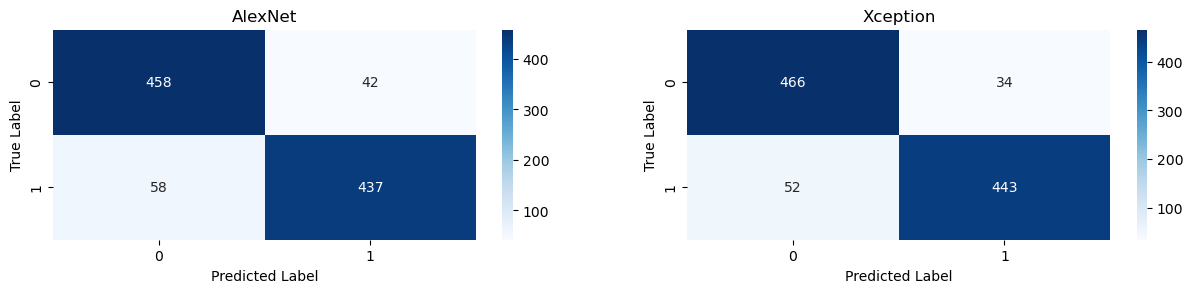

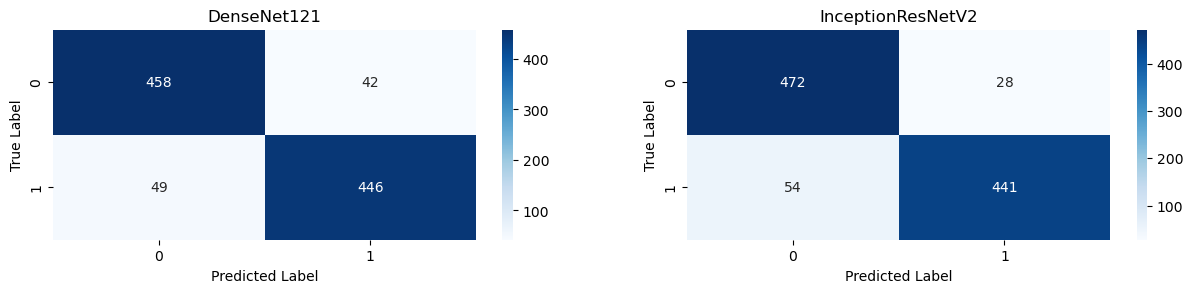

In [36]:
plt.figure(figsize=(15,6))

plt.subplot(221)
cm = confusion_matrix(y_test, y_pred_test_alexnet)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt="1")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('AlexNet')

plt.subplot(222)
cm = confusion_matrix(y_test, y_pred_test_xception)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt="1")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Xception')
plt.show()

plt.figure(figsize=(15,6))
plt.subplot(223)
cm = confusion_matrix(y_test, y_pred_test_densenet)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt="1")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DenseNet121')

plt.subplot(224)
cm = confusion_matrix(y_test, y_pred_test_inception)
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt="1")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('InceptionResNetV2')
plt.show()

By selecting the Xception's optimum probability threshold value of 0.367 and reclassifying the test set images for all 4 models we arrive at the above confusion matrixes.
 
We can see that they all perform very similar to each other. For our use case, we prioritized the minimization of False Negatives: we don't want to falsely inform someone that has malignant melanoma that it's benign. For this reason, we will move forward with the DenseNet model which has the lowest number of False Negatives. 

DenseNet has the least amount False Negatives (Type 2 Errors) but the highst False Positive (Type 1 Error) count of all the models( tied with AlexNet). The count of each type of error can be adjust based on the needs of the end user, specifically what their error tolerance is for each kind of error. A False Negative means that a patience will be told that they don't have cancer but in fact do and a False Positive means that a patient will be told that they have cancer when in fact they do not. Subjectively, False Negatives are a worse type of error since untreated melanoma can be fatal while a False Positive can lead to a scare about a benign skin mark.

In [52]:
# Convert predicted probabilities to binary predictions based on the threshold
y_pred = (y_pred_prob_test_inception.flatten() > best_thresh).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy: {:.4}".format(accuracy))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))
print("F1-Score: {:.4}".format(f1))

Accuracy: 0.9176
Precision: 0.9403
Recall: 0.8909
F1-Score: 0.9149


The threshold we choose has led to the above binary classification metric values. All values are near or above 90%. This means that 9 out of 10 predictions will be correct (accuracy). 9 out 10 positive predictions will be correctly positive (precision). The proportion of actual positive cases that were correctly identified by the model out of all actual positive cases is also 90% (recall); this means that 10% of patients with melanoma will be classified as not having melanoma. And, finally, F1-score is a balanced average of Precision and Recall informing us that the model gets 90% of predictions correct and there isn't an imbalance between precision and recall.

In [45]:
# predict on single image
single_image = tf.expand_dims(x[0], axis=0)
InceptionResNetV2_model.predict(single_image)

1/1 [==============================] - 3s 3s/step


array([[0.00257993]], dtype=float32)